Action1	二手车价格预测
used_car_train_20200313.csv
used_car_testB_20200421.csv
数据来自某交易平台的二手车交易记录
https://tianchi.aliyun.com/competition/entrance/231784/introduction
ToDo：给你一辆车的各个属性（除了price字段），预测它的价格
使用神经网络来完成预测			
1、使用神经网络完成预测（30points

字段表
Field	Description
SaleID	交易ID，唯一编码
name	汽车交易名称，已脱敏
regDate	汽车注册日期，例如20160101，2016年01月01日
model	车型编码，已脱敏
brand	汽车品牌，已脱敏
bodyType	车身类型：豪华轿车：0，微型车：1，厢型车：2，大巴车：3，敞篷车：4，双门汽车：5，商务车：6，搅拌车：7
fuelType	燃油类型：汽油：0，柴油：1，液化石油气：2，天然气：3，混合动力：4，其他：5，电动：6
gearbox	变速箱：手动：0，自动：1
power	发动机功率：范围 [ 0, 600 ]
kilometer	汽车已行驶公里，单位万km
notRepairedDamage	汽车有尚未修复的损坏：是：0，否：1
regionCode	地区编码，已脱敏
seller	销售方：个体：0，非个体：1
offerType	报价类型：提供：0，请求：1
creatDate	汽车上线时间，即开始售卖时间
price	二手车交易价格（预测目标）
v系列特征	匿名特征，包含v0-14在内15个匿名特征

In [1]:
## 基础工具
import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import jn
from IPython.display import display, clear_output
import time
import missingno as msno
#导入warnings包，利用过滤器来实现忽略警告语句。
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## 模型预测的
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

## 数据降维处理的
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA

import lightgbm as lgb
import xgboost as xgb

## 参数搜索和评价的
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
## 1) 载入训练集和测试集；
path = './2sc/'
train_data = pd.read_csv(path+'used_car_train_20200313.csv', sep=' ')
test_data = pd.read_csv(path+'used_car_testB_20200421.csv', sep=' ')

In [13]:
train_data

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,4840.0,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,4442.0,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,4841.0,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,2077.0,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,7672.0,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,149995,163978,3445.0,121.0,10,4.0,0.0,1.0,163,15.0,...,0.280264,0.000310,0.048441,0.071158,0.019174,1.988114,-2.983973,0.589167,-1.304370,-0.302592
149996,149996,184535,6880.0,116.0,11,0.0,0.0,0.0,125,10.0,...,0.253217,0.000777,0.084079,0.099681,0.079371,1.839166,-2.774615,2.553994,0.924196,-0.272160
149997,149997,147587,7215.0,60.0,11,1.0,1.0,0.0,90,6.0,...,0.233353,0.000705,0.118872,0.100118,0.097914,2.439812,-1.630677,2.290197,1.891922,0.414931
149998,149998,45907,5549.0,34.0,10,3.0,1.0,0.0,156,15.0,...,0.256369,0.000252,0.081479,0.083558,0.081498,2.075380,-2.633719,1.414937,0.431981,-1.659014


In [3]:
## 2) 简略观察数据(head()+shape)
train_data.head().append(train_data.tail())

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482
149995,149995,163978,20000607,121.0,10,4.0,0.0,1.0,163,15.0,...,0.280264,0.000310,0.048441,0.071158,0.019174,1.988114,-2.983973,0.589167,-1.304370,-0.302592
149996,149996,184535,20091102,116.0,11,0.0,0.0,0.0,125,10.0,...,0.253217,0.000777,0.084079,0.099681,0.079371,1.839166,-2.774615,2.553994,0.924196,-0.272160
149997,149997,147587,20101003,60.0,11,1.0,1.0,0.0,90,6.0,...,0.233353,0.000705,0.118872,0.100118,0.097914,2.439812,-1.630677,2.290197,1.891922,0.414931
149998,149998,45907,20060312,34.0,10,3.0,1.0,0.0,156,15.0,...,0.256369,0.000252,0.081479,0.083558,0.081498,2.075380,-2.633719,1.414937,0.431981,-1.659014
149999,149999,177672,19990204,19.0,28,6.0,0.0,1.0,193,12.5,...,0.284475,0.000000,0.040072,0.062543,0.025819,1.978453,-3.179913,0.031724,-1.483350,-0.342674


In [4]:
test_data.head().append(test_data.tail())

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,200000,133777,20000501,67.0,0,1.0,0.0,0.0,101,15.0,...,0.236520,0.000241,0.105319,0.046233,0.094522,3.619512,-0.280607,-2.019761,0.978828,0.803322
1,200001,61206,19950211,19.0,6,2.0,0.0,0.0,73,6.0,...,0.261518,0.000000,0.120323,0.046784,0.035385,2.997376,-1.406705,-1.020884,-1.349990,-0.200542
2,200002,67829,20090606,5.0,5,4.0,0.0,0.0,120,5.0,...,0.261691,0.090836,0.000000,0.079655,0.073586,-3.951084,-0.433467,0.918964,1.634604,1.027173
3,200003,8892,20020601,22.0,9,1.0,0.0,0.0,58,15.0,...,0.236050,0.101777,0.098950,0.026830,0.096614,-2.846788,2.800267,-2.524610,1.076819,0.461610
4,200004,76998,20030301,46.0,6,0.0,NaN,0.0,116,15.0,...,0.257000,0.000000,0.066732,0.057771,0.068852,2.839010,-1.659801,-0.924142,0.199423,0.451014
49995,249995,111443,20041005,4.0,4,0.0,NaN,1.0,150,15.0,...,0.263668,0.000292,0.141804,0.076393,0.039272,2.072901,-2.531869,1.716978,-1.063437,0.326587
49996,249996,152834,20130409,65.0,1,0.0,0.0,0.0,179,4.0,...,0.255310,0.000991,0.155868,0.108425,0.067841,1.358504,-3.290295,4.269809,0.140524,0.556221
49997,249997,132531,20041211,4.0,4,0.0,0.0,1.0,147,12.5,...,0.262933,0.000318,0.141872,0.071968,0.042966,2.165658,-2.417885,1.370612,-1.073133,0.270602
49998,249998,143405,20020702,40.0,1,4.0,0.0,1.0,176,15.0,...,0.282106,0.000023,0.067483,0.067526,0.009006,2.030114,-2.939244,0.569078,-1.718245,0.316379
49999,249999,78202,20090708,32.0,8,1.0,0.0,0.0,0,3.0,...,0.231449,0.103947,0.096027,0.062328,0.110180,-3.689090,2.032376,0.109157,2.202828,0.847469


describe种有每列的统计量，个数count、平均值mean、方差std、最小值min、中位数25% 50% 75% 、以及最大值 看这个信息主要是瞬间掌握数据的大概的范围以及每个值的异常值的判断，比如有的时候会发现999 9999 -1 等值这些其实都是nan的另外一种表达方式，有的时候需要注意下

In [5]:
#处理测试集数据
#将regDate转换为时间diff(汽车注册时间）
min_date = np.min(train_data["regDate"])
min_date

19910001

In [6]:
train_data["regDate"] - min_date

0         130401
1         120300
2         130402
3          50907
4         210102
           ...  
149995     90606
149996    181101
149997    191002
149998    150311
149999     80203
Name: regDate, Length: 150000, dtype: int64

In [7]:
temp = pd.to_datetime(train_data["regDate"], format="%Y%m%d", errors="coerce")
temp

0        2004-04-02
1        2003-03-01
2        2004-04-03
3        1996-09-08
4        2012-01-03
            ...    
149995   2000-06-07
149996   2009-11-02
149997   2010-10-03
149998   2006-03-12
149999   1999-02-04
Name: regDate, Length: 150000, dtype: datetime64[ns]

In [8]:
min_date = pd.to_datetime("19910101", format="%Y%m%d")
min_date

Timestamp('1991-01-01 00:00:00')

In [9]:
(temp - min_date).dt.days

0         4840.0
1         4442.0
2         4841.0
3         2077.0
4         7672.0
           ...  
149995    3445.0
149996    6880.0
149997    7215.0
149998    5549.0
149999    2956.0
Name: regDate, Length: 150000, dtype: float64

In [10]:
train_data["regDate"] = (pd.to_datetime(train_data["regDate"], format="%Y%m%d", errors="coerce") - min_date).dt.days
train_data

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,4840.0,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,4442.0,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,4841.0,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,2077.0,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,7672.0,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,149995,163978,3445.0,121.0,10,4.0,0.0,1.0,163,15.0,...,0.280264,0.000310,0.048441,0.071158,0.019174,1.988114,-2.983973,0.589167,-1.304370,-0.302592
149996,149996,184535,6880.0,116.0,11,0.0,0.0,0.0,125,10.0,...,0.253217,0.000777,0.084079,0.099681,0.079371,1.839166,-2.774615,2.553994,0.924196,-0.272160
149997,149997,147587,7215.0,60.0,11,1.0,1.0,0.0,90,6.0,...,0.233353,0.000705,0.118872,0.100118,0.097914,2.439812,-1.630677,2.290197,1.891922,0.414931
149998,149998,45907,5549.0,34.0,10,3.0,1.0,0.0,156,15.0,...,0.256369,0.000252,0.081479,0.083558,0.081498,2.075380,-2.633719,1.414937,0.431981,-1.659014


In [11]:
# 将createDate转换为时间diff(汽车售卖时间)
np.min(train_data["creatDate"])

20150618

In [12]:
min_date2 = pd.to_datetime("20150601", format="%Y%m%d")
train_data["creatDate"] = (pd.to_datetime(train_data["creatDate"], format="%Y%m%d", errors="coerce") - min_date).dt.days
train_data["creatDate"]

0         9225
1         9199
2         9223
3         9202
4         9203
          ... 
149995    9217
149996    9202
149997    9218
149998    9222
149999    9195
Name: creatDate, Length: 150000, dtype: int64

In [14]:
#汽车使用时间
train_data["usedTime"] = train_data["creatDate"] - train_data["regDate"]
train_data["usedTime"]

0         4385.0
1         4757.0
2         4382.0
3         7125.0
4         1531.0
           ...  
149995    5772.0
149996    2322.0
149997    2003.0
149998    3673.0
149999    6239.0
Name: usedTime, Length: 150000, dtype: float64

In [15]:
#处理测试集数据
test_data["regDate"] = (pd.to_datetime(test_data["regDate"], format="%Y%m%d", errors="coerce") - min_date).dt.days
test_data["creatDate"] = (pd.to_datetime(test_data["creatDate"], format="%Y%m%d", errors="coerce") - min_date).dt.days
test_data["usedTime"] = test_data["creatDate"] - test_data["regDate"]

In [17]:
## 1) 通过describe()来熟悉数据的相关统计量
train_data.describe()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,usedTime
count,150000.000000,150000.000000,138653.000000,149999.000000,150000.000000,145494.000000,141320.000000,144019.000000,150000.000000,150000.000000,...,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,138653.000000
mean,74999.500000,68349.172873,4778.717453,47.129021,8.052733,1.792369,0.375842,0.224943,119.316547,12.597160,...,0.044923,0.124692,0.058144,0.061996,-0.001000,0.009035,0.004813,0.000313,-0.000688,4432.082407
std,43301.414527,61103.875095,1953.203543,49.536040,7.864956,1.760640,0.548677,0.417546,177.168419,3.919576,...,0.051743,0.201410,0.029186,0.035692,3.772386,3.286071,2.517478,1.288988,1.038685,1953.201975
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,-9.168192,-5.558207,-9.639552,-4.153899,-6.546556,88.000000
25%,37499.750000,11156.000000,3290.000000,10.000000,1.000000,0.000000,0.000000,0.000000,75.000000,12.500000,...,0.000038,0.062474,0.035334,0.033930,-3.722303,-1.951543,-1.871846,-1.057789,-0.437034,2941.000000
50%,74999.500000,51638.000000,4788.000000,30.000000,6.000000,1.000000,0.000000,0.000000,110.000000,15.000000,...,0.000812,0.095866,0.057014,0.058484,1.624076,-0.358053,-0.130753,-0.036245,0.141246,4418.000000
75%,112499.250000,118841.250000,6272.000000,66.000000,13.000000,3.000000,1.000000,0.000000,150.000000,15.000000,...,0.102009,0.125243,0.079382,0.087491,2.844357,1.255022,1.776933,0.942813,0.680378,5927.000000
max,149999.000000,196812.000000,9111.000000,247.000000,39.000000,7.000000,6.000000,1.000000,19312.000000,15.000000,...,0.151420,1.404936,0.160791,0.222787,12.357011,18.819042,13.847792,11.147669,8.658418,9222.000000


In [18]:
## 2) 通过info()来熟悉数据类型
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 32 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SaleID             150000 non-null  int64  
 1   name               150000 non-null  int64  
 2   regDate            138653 non-null  float64
 3   model              149999 non-null  float64
 4   brand              150000 non-null  int64  
 5   bodyType           145494 non-null  float64
 6   fuelType           141320 non-null  float64
 7   gearbox            144019 non-null  float64
 8   power              150000 non-null  int64  
 9   kilometer          150000 non-null  float64
 10  notRepairedDamage  150000 non-null  object 
 11  regionCode         150000 non-null  int64  
 12  seller             150000 non-null  int64  
 13  offerType          150000 non-null  int64  
 14  creatDate          150000 non-null  int64  
 15  price              150000 non-null  int64  
 16  v_

In [19]:
## 1) 查看每列的存在nan情况
train_data.isnull().sum()

SaleID                   0
name                     0
regDate              11347
model                    1
brand                    0
bodyType              4506
fuelType              8680
gearbox               5981
power                    0
kilometer                0
notRepairedDamage        0
regionCode               0
seller                   0
offerType                0
creatDate                0
price                    0
v_0                      0
v_1                      0
v_2                      0
v_3                      0
v_4                      0
v_5                      0
v_6                      0
v_7                      0
v_8                      0
v_9                      0
v_10                     0
v_11                     0
v_12                     0
v_13                     0
v_14                     0
usedTime             11347
dtype: int64

In [22]:
train_data['notRepairedDamage'].value_counts()

0.0    111361
-       24324
1.0     14315
Name: notRepairedDamage, dtype: int64

In [23]:
# #可以看出来‘ - ’也为空缺值，因为很多模型对nan有直接的处理，这里我们先不做处理，先替换成nan
# train_data['notRepairedDamage'].replace('-', np.nan, inplace=True)
# train_data['notRepairedDamage'].value_counts()
 # - 应该为缺失值，2万多条drop很可惜，用众数0填充
train_data["notRepairedDamage"].replace("-", "0.0", inplace=True)
train_data["notRepairedDamage"].value_counts()

0.0    135685
1.0     14315
Name: notRepairedDamage, dtype: int64

In [24]:
test_data["notRepairedDamage"].replace("-", "0.0", inplace=True)
test_data["notRepairedDamage"].value_counts()

0.0    45293
1.0     4707
Name: notRepairedDamage, dtype: int64

In [25]:
train_data["notRepairedDamage"] = train_data["notRepairedDamage"].astype("float64")
test_data["notRepairedDamage"] = test_data["notRepairedDamage"].astype("float64")

In [26]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 32 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SaleID             150000 non-null  int64  
 1   name               150000 non-null  int64  
 2   regDate            138653 non-null  float64
 3   model              149999 non-null  float64
 4   brand              150000 non-null  int64  
 5   bodyType           145494 non-null  float64
 6   fuelType           141320 non-null  float64
 7   gearbox            144019 non-null  float64
 8   power              150000 non-null  int64  
 9   kilometer          150000 non-null  float64
 10  notRepairedDamage  150000 non-null  float64
 11  regionCode         150000 non-null  int64  
 12  seller             150000 non-null  int64  
 13  offerType          150000 non-null  int64  
 14  creatDate          150000 non-null  int64  
 15  price              150000 non-null  int64  
 16  v_

In [27]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SaleID             50000 non-null  int64  
 1   name               50000 non-null  int64  
 2   regDate            46264 non-null  float64
 3   model              50000 non-null  float64
 4   brand              50000 non-null  int64  
 5   bodyType           48496 non-null  float64
 6   fuelType           47076 non-null  float64
 7   gearbox            48032 non-null  float64
 8   power              50000 non-null  int64  
 9   kilometer          50000 non-null  float64
 10  notRepairedDamage  50000 non-null  float64
 11  regionCode         50000 non-null  int64  
 12  seller             50000 non-null  int64  
 13  offerType          50000 non-null  int64  
 14  creatDate          50000 non-null  int64  
 15  v_0                50000 non-null  float64
 16  v_1                500

In [28]:
#查看数据缺失值
train_data.isnull().sum()

SaleID                   0
name                     0
regDate              11347
model                    1
brand                    0
bodyType              4506
fuelType              8680
gearbox               5981
power                    0
kilometer                0
notRepairedDamage        0
regionCode               0
seller                   0
offerType                0
creatDate                0
price                    0
v_0                      0
v_1                      0
v_2                      0
v_3                      0
v_4                      0
v_5                      0
v_6                      0
v_7                      0
v_8                      0
v_9                      0
v_10                     0
v_11                     0
v_12                     0
v_13                     0
v_14                     0
usedTime             11347
dtype: int64

In [29]:
test_data.isnull().sum()

SaleID                  0
name                    0
regDate              3736
model                   0
brand                   0
bodyType             1504
fuelType             2924
gearbox              1968
power                   0
kilometer               0
notRepairedDamage       0
regionCode              0
seller                  0
offerType               0
creatDate               0
v_0                     0
v_1                     0
v_2                     0
v_3                     0
v_4                     0
v_5                     0
v_6                     0
v_7                     0
v_8                     0
v_9                     0
v_10                    0
v_11                    0
v_12                    0
v_13                    0
v_14                    0
usedTime             3736
dtype: int64

In [30]:
train_data.shape, test_data.shape

((150000, 32), (50000, 31))

In [40]:
#找到数值类型和非数值类型的特征
numerical_cols = train_data.select_dtypes(exclude="object").columns
numerical_cols

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6',
       'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14',
       'usedTime'],
      dtype='object')

In [41]:
# 找到非数值类型的特征
object_cols = train_data.select_dtypes(include="object").columns
object_cols

Index([], dtype='object')

In [37]:
#以下两个类别特征严重倾斜，一般不会对预测有什么帮助，故这边先删掉
train_data["seller"].value_counts()
train_data["offerType"].value_counts()
del train_data["seller"]
del train_data["offerType"]
del test_data["seller"]
del test_data["offerType"]

In [42]:
#了解预测值的分布
train_data['price']

0         1850
1         3600
2         6222
3         2400
4         5200
          ... 
149995    5900
149996    9500
149997    7500
149998    4999
149999    4700
Name: price, Length: 150000, dtype: int64

In [44]:
train_data['price'].value_counts()

500      2337
1500     2158
1200     1922
1000     1850
2500     1821
         ... 
25321       1
8886        1
8801        1
37920       1
8188        1
Name: price, Length: 3763, dtype: int64

In [45]:
train_data["SaleID"].value_counts()

2047      1
113949    1
15661     1
13612     1
3371      1
         ..
8913      1
10960     1
53967     1
56014     1
0         1
Name: SaleID, Length: 150000, dtype: int64

In [46]:
# 不要id和price
feature_cols = [str(col) for col in numerical_cols  if str(col) not in ["SaleID", "price"]]
# feature_cols = [str(col) for col in numerical_cols  if str(col) not in ["SaleID", "price", "usedTime"]]
feature_cols

['name',
 'regDate',
 'model',
 'brand',
 'bodyType',
 'fuelType',
 'gearbox',
 'power',
 'kilometer',
 'notRepairedDamage',
 'regionCode',
 'creatDate',
 'v_0',
 'v_1',
 'v_2',
 'v_3',
 'v_4',
 'v_5',
 'v_6',
 'v_7',
 'v_8',
 'v_9',
 'v_10',
 'v_11',
 'v_12',
 'v_13',
 'v_14',
 'usedTime']

In [47]:
# 提取特征列
X_data = train_data[feature_cols]
Y_data = train_data["price"]
X_test = test_data[feature_cols]

In [49]:
#定义统计函数，方便了解数据分布
def show_stats(data):
    print("min： ", np.min(data))
    print("max： ", np.max(data))
    print("ptp： ", np.ptp(data))
    print("mean： ", np.mean(data))
    print("std： ", np.std(data))
    print("var： ", np.var(data))

In [72]:
print("训练集Price的统计情况")
show_stats(Y_data)

训练集Price的统计情况
min：  11
max：  99999
ptp：  99988
mean：  5923.327333333334
std：  7501.973469876438
var：  56279605.94272992


In [57]:
train_data.corr()#协方差

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,usedTime
SaleID,1.000000,-0.002299,-0.002685,0.000659,-0.001754,-0.005163,-0.001584,0.001153,0.000873,-0.001115,...,-0.000397,0.001164,-0.000046,-0.000749,0.000983,0.001276,0.000249,0.000162,-0.000209,0.002699
name,-0.002299,1.000000,-0.025793,0.016080,0.040678,0.034532,0.014880,0.026104,0.000236,-0.007613,...,-0.638191,0.057199,0.235341,0.008455,0.576758,-0.258582,0.090897,0.007558,-0.011303,0.025760
regDate,-0.002685,-0.025793,1.000000,0.144539,0.028218,0.104169,0.274515,0.139194,0.095313,-0.515652,...,0.093595,-0.009285,0.768312,0.146484,-0.236960,-0.204743,0.742756,0.411235,0.174935,-0.999988
model,0.000659,0.016080,0.144539,1.000000,0.358765,0.207208,0.048767,0.019314,0.031245,-0.087445,...,0.015419,-0.100753,0.211149,0.423526,-0.058674,-0.079661,0.110157,0.400001,-0.513733,-0.144556
brand,-0.001754,0.040678,0.028218,0.358765,1.000000,0.114116,-0.079566,0.012914,-0.022391,-0.096262,...,-0.031185,-0.050022,0.015200,0.352137,0.043222,0.007571,-0.070912,0.320933,-0.207713,-0.028222
bodyType,-0.005163,0.034532,0.104169,0.207208,0.114116,1.000000,0.118717,0.099966,0.079632,-0.053212,...,-0.009374,-0.399415,0.220308,-0.051773,-0.082708,-0.293019,0.210039,-0.030675,-0.288897,-0.104173
fuelType,-0.001584,0.014880,0.274515,0.048767,-0.079566,0.118717,1.000000,0.171692,0.059315,0.099446,...,0.001499,0.000487,0.279369,-0.128720,-0.075217,-0.137755,0.302333,-0.049669,-0.021656,-0.274562
gearbox,0.001153,0.026104,0.139194,0.019314,0.012914,0.099966,0.171692,1.000000,0.156706,-0.046807,...,0.002201,0.011876,0.238381,-0.258017,-0.080558,-0.145925,0.291374,-0.203841,-0.044204,-0.139196
power,0.000873,0.000236,0.095313,0.031245,-0.022391,0.079632,0.059315,0.156706,1.000000,-0.019631,...,0.025648,-0.060397,0.155956,-0.140203,-0.092717,-0.122107,0.161990,-0.103430,-0.023808,-0.095285
kilometer,-0.001115,-0.007613,-0.515652,-0.087445,-0.096262,-0.053212,0.099446,-0.046807,-0.019631,1.000000,...,-0.024664,-0.017835,-0.407686,-0.149422,0.083358,0.066542,-0.370153,-0.285158,-0.120389,0.515636


In [58]:
train_data.corr()["price"] #0 不相关，正数正相关，复数负相关，数越大相关度越大

SaleID              -0.001043
name                 0.002030
regDate              0.610593
model                0.136983
brand               -0.043799
bodyType             0.241303
fuelType             0.200536
gearbox              0.329075
power                0.219834
kilometer           -0.440519
notRepairedDamage   -0.157523
regionCode           0.014036
creatDate            0.016916
price                1.000000
v_0                  0.628397
v_1                  0.060914
v_2                  0.085322
v_3                 -0.730946
v_4                 -0.147085
v_5                  0.164317
v_6                  0.068970
v_7                 -0.053024
v_8                  0.685798
v_9                 -0.206205
v_10                -0.246175
v_11                -0.275320
v_12                 0.692823
v_13                -0.013993
v_14                 0.035911
usedTime            -0.610510
Name: price, dtype: float64

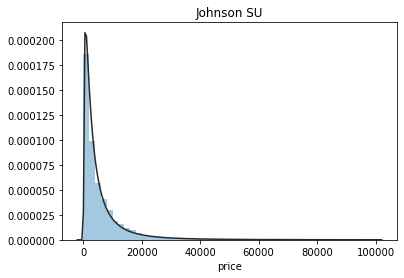

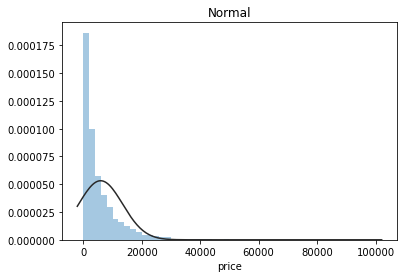

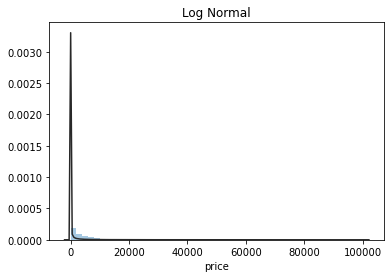

In [48]:
## 1) 总体分布概况（无界约翰逊分布等）
import scipy.stats as st
Y_data = train_data['price']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(Y_data, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(Y_data, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(Y_data, kde=False, fit=st.lognorm)

Skewness: 3.346487
Kurtosis: 18.995183


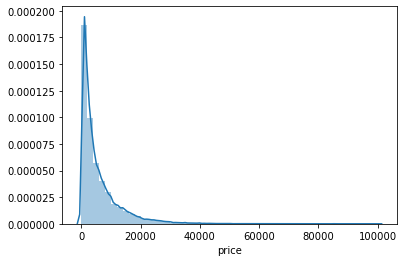

In [51]:
## 2) 查看skewness and kurtosis
sns.distplot(train_data['price']);
print("Skewness: %f" % train_data['price'].skew())
print("Kurtosis: %f" % train_data['price'].kurt())

In [53]:
train_data.skew(), train_data.kurt()

(SaleID               6.017846e-17
 name                 5.576058e-01
 regDate             -2.663287e-02
 model                1.484388e+00
 brand                1.150760e+00
 bodyType             9.915299e-01
 fuelType             1.595486e+00
 gearbox              1.317514e+00
 power                6.586318e+01
 kilometer           -1.525921e+00
 notRepairedDamage    2.753938e+00
 regionCode           6.888812e-01
 creatDate           -8.184920e-01
 price                3.346487e+00
 v_0                 -1.316712e+00
 v_1                  3.594543e-01
 v_2                  4.842556e+00
 v_3                  1.062920e-01
 v_4                  3.679890e-01
 v_5                 -4.737094e+00
 v_6                  3.680730e-01
 v_7                  5.130233e+00
 v_8                  2.046133e-01
 v_9                  4.195007e-01
 v_10                 2.522046e-02
 v_11                 3.029146e+00
 v_12                 3.653576e-01
 v_13                 2.679152e-01
 v_14               

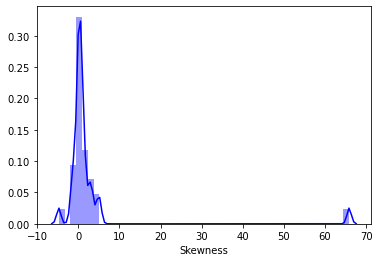

In [55]:
sns.distplot(train_data.skew(),color='blue',axlabel ='Skewness')

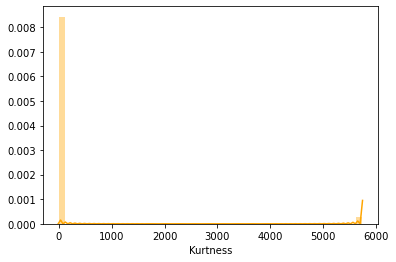

In [56]:
sns.distplot(train_data.kurt(),color='orange',axlabel ='Kurtness')

In [59]:
#补全缺失值
X_data = X_data.fillna(-1)
X_test = X_test.fillna(-1)

In [74]:
#训练、预测、输出结果
#和训练集Price的铜价情况作比较，欠拟合，需要调整n_estimator和learning_rate（调大）
# n_estimator=150, learning_rate=0.01  score:2220.7730
# n_estimator=500, learning_rate=0.01  score:2220.7730
#n_estimator=150, learning_rate=0.1    score:626.5755
#n_estimator=500, learning_rate=0.1    score:626.5755
model = xgb.XGBRegressor(n_estimator=500, learning_rate=0.1, max_depth=7)
model.fit(X_data, Y_data)
predict_y = model.predict(X_test)
print("XGBoost 预测结果的统计情况:")
show_stats(predict_y)

[20:06:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


XGBoost 预测结果的统计情况:
min：  -811.8549
max：  91640.914
ptp：  92452.766
mean：  5910.4775
std：  7337.314
var：  53836176.0


In [113]:
#输出结果
result = pd.DataFrame()
result["SaleID"] = test_data["SaleID"]
result["price"] = predict_y
result.loc[result["price"] <11, "price"] = 11
result[result["price"] < 11]

In [ ]:
result.to_csv("ans_xgb.csv", index=False)

In [101]:
#模型融合，XGBoost，LightGBM两个模型融合，相加除以2
#数据集切分
x_train, x_val, y_train, y_val = train_test_split(X_data, Y_data, test_size=0.2)
#构建xgb模型
def build_model_xgb(x_train, y_train):
    model = xgb.XGBRegressor(n_estimators=150, learning_rate=0.1, max_depth=7)
    model.fit(x_train, y_train)
    return model

In [102]:
#构建lgb模型
def build_model_lgb(x_train, y_train):
    estimator = lgb.LGBMRegressor(n_estimators=150, num_leaves=127)
    # 设置超参数的范围
    param_grid = {"learning_rate": [0.01, 0.05, 0.1, 0.2]}
    model = GridSearchCV(estimator, param_grid)
    model.fit(x_train, y_train)
    return model

In [103]:
#XGBoost
model_xgb = build_model_xgb(x_train, y_train)
val_xgb = model_xgb.predict(x_val)
MAE_xgb = mean_absolute_error(y_val, val_xgb)
print("XGBoost Validation MAE: ", MAE_xgb)

XGBoost Validation MAE:  611.6147594983806


In [104]:
model_xgb2 = build_model_xgb(X_data, Y_data)
result_xgb = model_xgb.predict(X_test)
print("XGB预测统计结果: ")
show_stats(result_xgb)

XGB预测统计结果: 
min：  -805.514
max：  92519.23
ptp：  93324.74
mean：  5905.333
std：  7331.237
var：  53747030.0


In [105]:
#LightGB训练
model_lgb = build_model_lgb(x_train, y_train)
val_lgb = model_lgb.predict(x_val)
MAE_lgb = mean_absolute_error(y_val, val_lgb)
print("XGBoost Validation MAE: ", MAE_lgb)

XGBoost Validation MAE:  590.5405753626334


In [106]:
model_lgb2 = build_model_lgb(X_data, Y_data)
result_lgb = model_xgb.predict(X_test)
print("lgb预测统计结果: ")
show_stats(result_lgb)

lgb预测统计结果: 
min：  -805.514
max：  92519.23
ptp：  93324.74
mean：  5905.333
std：  7331.237
var：  53747030.0


In [107]:
#权重分配
predict_y = (1 - MAE_lgb/(MAE_xgb + MAE_lgb))*result_lgb + (1 - MAE_xgb/(MAE_xgb + MAE_lgb))*result_xgb

In [108]:
print("lgb 权重:", 1 - MAE_lgb/(MAE_xgb + MAE_lgb))
print("xgb 权重:", 1 - MAE_xgb/(MAE_xgb + MAE_lgb))

lgb 权重: 0.5087651668318653
xgb 权重: 0.49123483316813477


In [114]:
result = pd.DataFrame()
result["SaleID"] = test_data["SaleID"]
result["price"] = predict_y
result.loc[result["price"] <11, "price"] = 11
result[result["price"] < 11]

,SaleID,price


In [115]:
print("xgb&lgb 预测结果统计情况: ")
show_stats(predict_y)

xgb&lgb 预测结果统计情况: 
min：  -805.514
max：  92519.23
ptp：  93324.74
mean：  5905.333
std：  7331.237
var：  53747030.0


In [117]:
result.to_csv("ans_xgb_lgb2.csv", index=False)